In [1]:
%matplotlib inline
%load_ext rpy2.ipython

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product


## Archimedes procedure for porous material density determination

Experimental procedure is as follow, for further detail refer to standard ISO 5017. 

1. Measure temperature of liquid to determine its ($\rho_{\text{liq}}$) and find object theoretical full density ( $\rho_{\text{solid}}$ ) from datasheet
2. Measure mass of sample(s) in air ($m_1$)
3. Impregnate sample(s) in fluid (Isopropanol) 
4. Measure mass of wet sample(s) suspended in fluid ($m_2$)
5. Remove sample from balance and measure mass of soaked piece ($m_3$)

\begin{equation}
    \text{bulk density}, \rho_b = \frac{m_1}{m_3-m_2}*\rho_{\text{liq}}
\end{equation}

\begin{equation}
    \text{true density}, \pi_d = \frac{ \rho_b}{\rho_{\text{solid}}} * 100
\end{equation}

Parts using two powder type are made. Parts labeled bimodal should have a higher density then parts labelled unimodal.

## Load Data from excel sheet

In [2]:
data = pd.read_excel('./data/green_sample_benchmark.xls', sheet_name = 'archimedes', index_col= [0,1])
iso_density = pd.read_excel('./data/green_sample_benchmark.xls', sheet_name = 'arch_param', index_col= 0)

## Display first few row of excel sheet

In [3]:
data.head()

powder type  dry weight  wet coated  coated weight  exp  operator
batch ID                                                                    
4     3.0     Unimodal     14.8038     13.2572        15.9512    1         1
      3.0     Unimodal     14.7935     13.2525        15.9485    1         1
      8.0     Unimodal     15.2090     13.6240        16.3252    1         1
      8.0     Unimodal     15.2038     13.6184        16.3211    1         1
      14.0    Unimodal     15.3370     13.7548        16.4814    1         1

## Carrier fluid density

Density of the carrier fluid ($\rho_{\text{liq}}$) is necessary for density calculation. Since the density of the fluid fluctuate depending on temperature and temperature varies from experiment to experiment, it is recorded for each experiment. For experiment 2 it was recorded at the beginning and at the end.

In [4]:
iso_density

,density isopropanol
exp,
1,0.7842
2,0.7842
2,0.7838


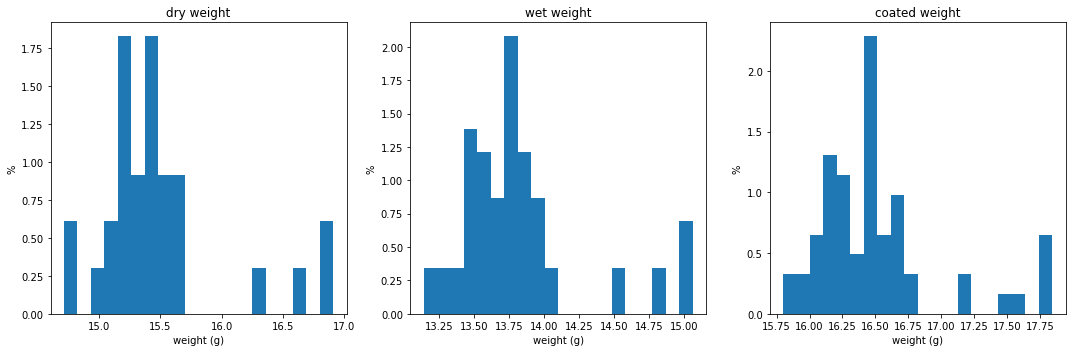

In [5]:
def plot_hist(data, b):
    fig, axes = plt.subplots(1,3, figsize = (15,5))
    axes[0].hist(data['dry weight'], bins = b, density = True)
    axes[0].set_title('dry weight')
    axes[0].set_xlabel('weight (g)')
    axes[0].set_ylabel('%')

    axes[1].hist(data['wet coated'], bins = b, density = True)
    axes[1].set_title('wet weight')
    axes[1].set_xlabel('weight (g)')
    axes[1].set_ylabel('%')

    axes[2].hist(data['coated weight'], bins = b, density = True)
    axes[2].set_title('coated weight')
    axes[2].set_xlabel('weight (g)')
    axes[2].set_ylabel('%')
    
    plt.tight_layout()
    plt.show()

plot_hist(data, 20)

## Compute density
Each sample was measured 3 times at each stage. Since we are only interested in the uncertainty in the true density ($\pi_t$), a cartesian product of each measured weights (dry, wet and coated) and liquid density is done for each sample in order to compute true density.

In [6]:
density_df = pd.DataFrame(columns = ['batch', 'id', 'density', 'operator', 'powder'])

# density of stainless steel 316L (g/cc) taken from data sheet
den_ss316 = 8.0

unique_id = 0

# iterate over each sample to do cartesian product
for idx in data.index.unique():
    sample = data.loc[idx]

    op = int(np.unique(sample['operator']).squeeze())
    powder = str(np.unique(sample['powder type']).squeeze())
    batch = idx[0]

    d_weight = sample['dry weight'].to_numpy()
    wc_weight = sample['wet coated'].to_numpy()
    c_weight = sample['coated weight'].to_numpy()

    exp_num = sample['exp']
    # density of liquid taken from datasheet
    iso_den = iso_density.loc[exp_num].to_numpy()
    
    # cartesian product
    prod = product(d_weight, wc_weight, c_weight, iso_den)

    for d_w, wc_w, c_w, iso_d in prod:
        #compute true density refer to equation on top
        den = (d_w/(c_w - wc_w)*iso_d)/den_ss316*100
        new_entry = {
            'batch' : batch,
            'id' : unique_id,
            'density' : float(den.squeeze()),
            'operator' : op,
            'powder' : powder
        }

        density_df = density_df.append(new_entry, ignore_index = True)
    
    unique_id += 1

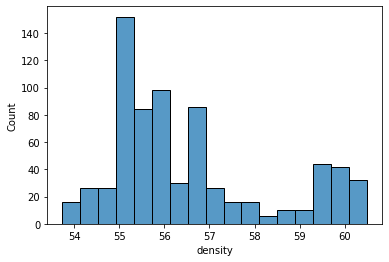

In [7]:
ax = sns.histplot(density_df['density'])

In [8]:
density_df.head()

,batch,id,density,operator,powder
0,4,0,53.865720,1,Unimodal
1,4,0,53.865720,1,Unimodal
2,4,0,53.919760,1,Unimodal
3,4,0,53.919760,1,Unimodal
4,4,0,53.771909,1,Unimodal


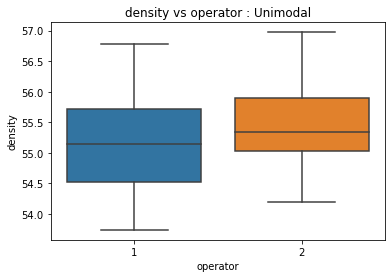

In [9]:
unimodal_df = density_df[density_df['powder'] == 'Unimodal']
fig, ax = plt.subplots()
ax.set_title('density vs operator : Unimodal')
sns.boxplot(x = 'operator', y ='density', data = unimodal_df, ax = ax)
plt.show()

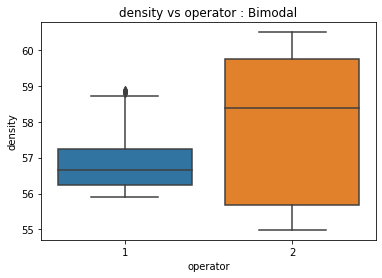

In [10]:
bimodal_df = density_df[density_df['powder'] == 'Bimodal']
fig, ax = plt.subplots()
ax.set_title('density vs operator : Bimodal')
sns.boxplot(x = 'operator', y ='density', data = bimodal_df, ax = ax)
plt.show()

In [29]:
%%R -i density_df

library(lme4)
library(lmerTest)

In [11]:
%%R -i density_df

fixed_lm <- lm(density ~ factor(operator) + factor(powder), data = density_df)
summary(fixed_lm)


Call:
lm(formula = density ~ factor(operator) + factor(powder), data = density_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7923 -0.8421 -0.2040  1.0918  2.7125 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             57.1147     0.1011 565.037  < 2e-16 ***
factor(operator)2        0.6651     0.1089   6.106 1.68e-09 ***
factor(powder)Unimodal  -2.1805     0.1029 -21.185  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.378 on 717 degrees of freedom
Multiple R-squared:  0.404,	Adjusted R-squared:  0.4024 
F-statistic:   243 on 2 and 717 DF,  p-value: < 2.2e-16



In [12]:
%%R
anova(fixed_lm)

Analysis of Variance Table

Response: density
                  Df  Sum Sq Mean Sq F value    Pr(>F)    
factor(operator)   1   70.77   70.77   37.28 1.676e-09 ***
factor(powder)     1  852.01  852.01  448.79 < 2.2e-16 ***
Residuals        717 1361.20    1.90                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


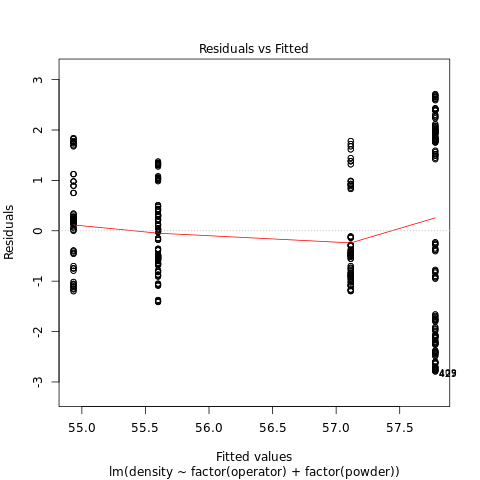

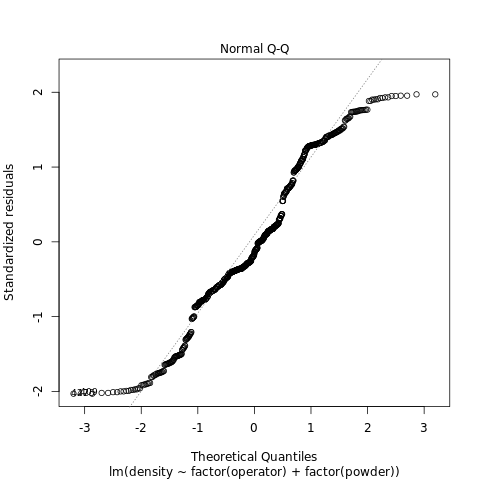

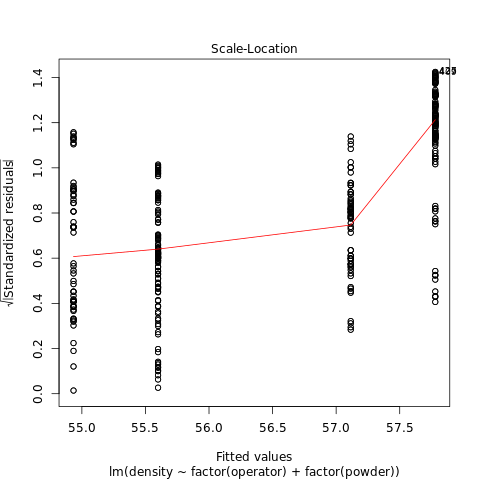

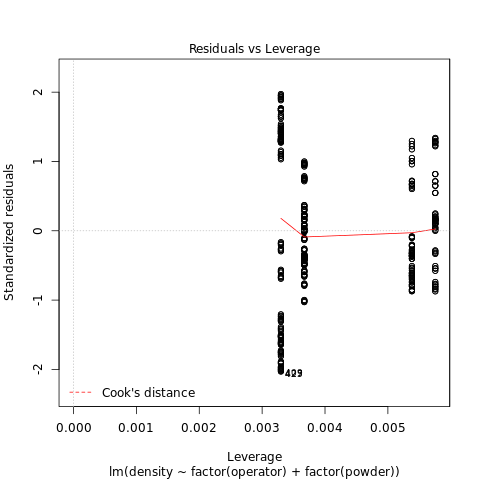

In [13]:
%%R
plot(fixed_lm)

In [22]:
%%R

mixed_lm_1 <- lmer(density ~ factor(operator) + factor(powder) + (1|id), data = density_df)
summary(mixed_lm_1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: density ~ factor(operator) + factor(powder) + (1 | id)
   Data: density_df

REML criterion at convergence: 128.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.22405 -0.71752 -0.00325  0.70615  2.22391 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 1.74523  1.3211  
 Residual             0.05333  0.2309  
Number of obs: 720, groups:  id, 30

Fixed effects:
                       Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)             57.0659     0.4093 27.0312 139.415  < 2e-16 ***
factor(operator)2        0.6651     0.4827 27.0133   1.378 0.179585    
factor(powder)Unimodal  -2.0759     0.4838 27.0133  -4.291 0.000204 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) fct()2
fctr(prtr)2 -0.590       
fctr(pwdr)U -0.552  0.000


In [23]:
%%R
anova(mixed_lm_1)

Type III Analysis of Variance Table with Satterthwaite's method
                  Sum Sq Mean Sq NumDF  DenDF F value    Pr(>F)    
factor(operator) 0.10124 0.10124     1 27.013  1.8982 0.1795855    
factor(powder)   0.98192 0.98192     1 27.013 18.4113 0.0002041 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [24]:
%%R -i density_df

mixed_lm_2 <- lmer(density ~ factor(operator) + factor(powder) + (1|operator/id), data = density_df)
summary(mixed_lm_1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: density ~ factor(operator) + factor(powder) + (1 | id)
   Data: density_df

REML criterion at convergence: 128.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.22405 -0.71752 -0.00325  0.70615  2.22391 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 1.74523  1.3211  
 Residual             0.05333  0.2309  
Number of obs: 720, groups:  id, 30

Fixed effects:
                       Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)             57.0659     0.4093 27.0312 139.415  < 2e-16 ***
factor(operator)2        0.6651     0.4827 27.0133   1.378 0.179585    
factor(powder)Unimodal  -2.0759     0.4838 27.0133  -4.291 0.000204 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) fct()2
fctr(prtr)2 -0.590       
fctr(pwdr)U -0.552  0.000


In [25]:
%%R
anova(mixed_lm_2)

Type III Analysis of Variance Table with Satterthwaite's method
                  Sum Sq Mean Sq NumDF   DenDF F value    Pr(>F)    
factor(operator) 0.05041 0.05041     1 104.714  0.9453 0.3331663    
factor(powder)   0.98178 0.98178     1  27.008 18.4088 0.0002043 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [27]:
%%R -i density_df

mixed_lm_3 <- lmer(density ~ factor(operator) + factor(powder) + (1|batch), data = density_df)
summary(mixed_lm_3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: density ~ factor(operator) + factor(powder) + (1 | batch)
   Data: density_df

REML criterion at convergence: 1635.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2138 -0.5984 -0.1212  0.5072  3.0013 

Random effects:
 Groups   Name        Variance Std.Dev.
 batch    (Intercept) 1.8684   1.3669  
 Residual             0.5379   0.7334  
Number of obs: 720, groups:  batch, 7

Fixed effects:
                       Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)             57.8823     0.7917   5.0343  73.111 8.16e-09 ***
factor(operator)2       -0.4863     0.0766 715.0535  -6.349 3.85e-10 ***
factor(powder)Unimodal  -2.2558     1.0457   5.0025  -2.157   0.0834 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) fct()2
fctr(prtr)2 -0.065       
fctr(pwdr)U -0.754  0.002


In [28]:
%%R
compare_lm = anova(mixed_lm_1, mixed_lm_2, mixed_lm_3, fixed_lm)
compare_lm


R[write to console]: refitting model(s) with ML (instead of REML)

Data: density_df
Models:
fixed_lm: density ~ factor(operator) + factor(powder)
mixed_lm_1: density ~ factor(operator) + factor(powder) + (1 | id)
mixed_lm_3: density ~ factor(operator) + factor(powder) + (1 | batch)
mixed_lm_2: density ~ factor(operator) + factor(powder) + (1 | operator/id)
           Df    AIC     BIC   logLik deviance  Chisq Chi Df Pr(>Chisq)    
fixed_lm    4 2509.8 2528.14 -1250.91   2501.8                             
mixed_lm_1  5  137.9  160.80   -63.95    127.9 2373.9      1     <2e-16 ***
mixed_lm_3  5 1644.0 1666.87  -816.98   1634.0    0.0      0          1    
mixed_lm_2  6  139.9  167.37   -63.95    127.9 1506.1      1     <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
